## CNN - Data Augmentation - Reduce over fitting

In [30]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

#### Retreive Data - OS and Filesystem

In [2]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=URL, extract=True)
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [3]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


#### Helping Functions

In [8]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [9]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  


#### Batch and Image Parameters

In [4]:
BATCH_SIZE = 100
IMG_SHAPE  = 150 # Our training data consists of images with width of 150 pixels and height of 150 pixels

#### Augment Images

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2000 images belonging to 2 classes.


In [6]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


#### Plot Augmented Images

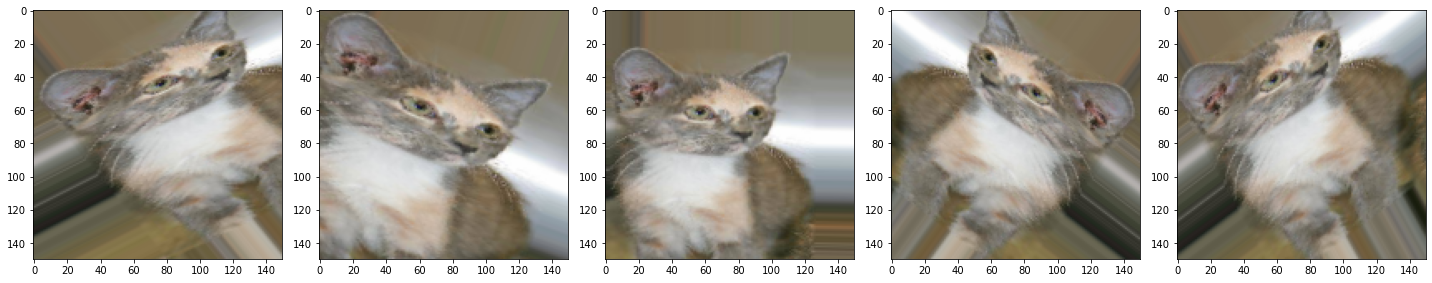

In [10]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [11]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


#### Create Model

In [40]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),  # 50% of the values will be set to zero. This helps to prevent overfitting
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

#### Fit Model

In [41]:
epochs=100
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/100
20/20 [==============================] - 17s 835ms/step - loss: 0.7548 - accuracy: 0.4878 - val_loss: 0.6971 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 16s 813ms/step - loss: 0.6958 - accuracy: 0.5030 - val_loss: 0.6762 - val_accuracy: 0.5020
Epoch 3/100
20/20 [==============================] - 16s 820ms/step - loss: 0.6819 - accuracy: 0.5551 - val_loss: 0.6498 - val_accuracy: 0.6170
Epoch 4/100
20/20 [==============================] - 16s 825ms/step - loss: 0.6645 - accuracy: 0.5767 - val_loss: 0.6485 - val_accuracy: 0.5810
Epoch 5/100
20/20 [==============================] - 16s 812ms/step - loss: 0.6551 - accuracy: 0.5972 - val_loss: 0.6135 - val_accuracy: 0.6580
Epoch 6/100
20/20 [==============================] - 16s 809ms/step - loss: 0.6331 - accuracy: 0.6377 - val_loss: 0.6067 - val_accuracy: 0.6740
Epoch 7/100
20/20 [==============================] - 16s 807ms/step - loss: 0.6525 - accuracy: 0.6092 - val_loss: 0.7294 - val_accuracy:

In [42]:
#!mkdir -p colab_model


In [2]:
model_filename = "colab_model/04_cat_dogs_aug_model"

In [44]:
model.save(model_filename) 

INFO:tensorflow:Assets written to: colab_model/04_cat_dogs_aug_model/assets


In [45]:
!cp -r colab_model/04_cat_dogs_aug_model /content/drive/MyDrive/ColabModels/

#### Evaluate Model

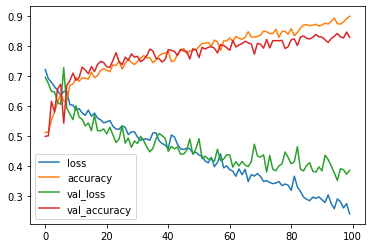

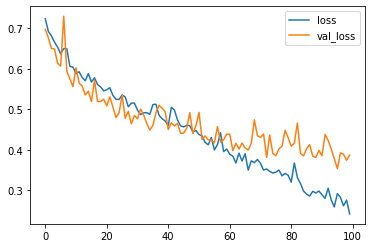

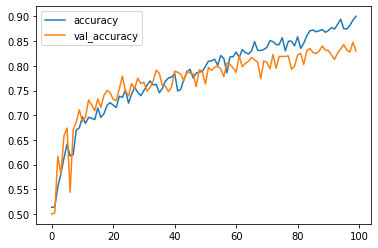

In [46]:
pd.DataFrame(model.history.history).head()
pd.DataFrame(model.history.history).plot()
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()
losses[['accuracy','val_accuracy']].plot()

#### Reload Saved Model

In [12]:
filename = "04_cat_dogs_aug_model"
saved_model_filename = "G:\\My Drive\\ColabModels\\" + filename
saved_model_filename

'G:\\My Drive\\ColabModels\\04_cat_dogs_aug_model'

In [13]:
new_model = tf.keras.models.load_model(saved_model_filename)
new_model.summary()

In [14]:
loss, acc = new_model.evaluate(val_data_gen, verbose=2)
print(f'Restored model, accuracy: {100 * acc}')

10/10 - 6s - loss: 0.3868 - accuracy: 0.8300
Restored model, accuracy: 82.99999833106995


#### Find Class Labels

In [233]:
# optional
def find_class_labels(data_gen):
    data_gen.class_indices
    dataset_labels = sorted(data_gen.class_indices.items(),
                        key=lambda pair:pair[1])
    dataset_labels = np.array([key.title() for key, value in dataset_labels])
    return dataset_labels

In [240]:
 # any one will work

In [241]:
dataset_labels = find_class_labels(val_data_gen)

In [242]:
dataset_labels = find_class_labels(train_data_gen)

In [243]:
dataset_labels = ['Cats','Dogs']

#### Prediction on validation batch

In [219]:
# Get data as a batch - batch has image and label size 100
val_image_batch, val_label_batch = next(iter(val_data_gen))

In [220]:
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (100, 150, 150, 3)


In [184]:
# batch label : cat or dog
# val_label_batch

##### Predict

In [221]:
model_predictions = new_model.predict(val_image_batch)

In [222]:
pred_df = pd.DataFrame(model_predictions)
pred_df.columns = dataset_labels
print("Prediction results for the first elements")
pred_df.head()

Prediction results for the first elements


,Cats,Dogs
0,0.232803,-0.177681
1,-3.628679,3.036582
2,4.613917,-5.326288
3,-1.885629,1.553173
4,-0.723571,0.627168


#### Misclassified Examples

In [223]:
predicted_label_ids = np.argmax(model_predictions, axis=-1)

In [226]:
n = 11
print(int(val_label_batch[n]))
print(int(predicted_label_ids[n]))

1
1


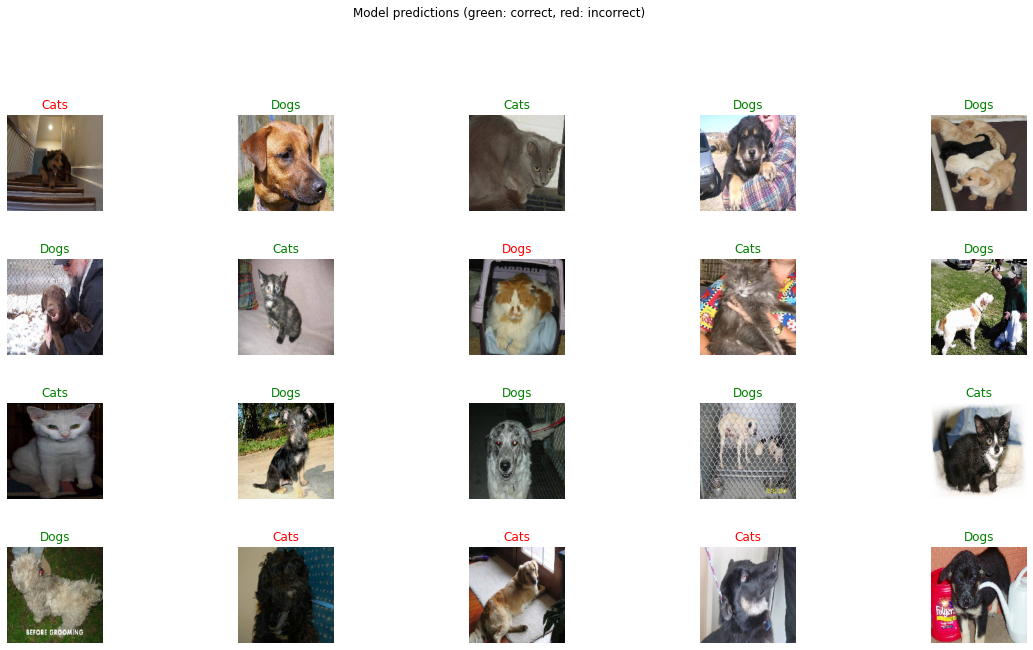

In [227]:
plt.figure(figsize=(20,15))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
    if (int(predicted_label_ids[n]) == int(val_label_batch[n])) :
        color = 'green'
    else:
        color = 'red'
    plt.subplot(6,5,n+1)
    plt.imshow(val_image_batch[n])
    plt.title(f"{dataset_labels[predicted_label_ids[n]]}".title(), color=color)
    #plt.title(f"True : {val_label_batch[n]} Predicted :{predicted_label_ids[n]}".title())
    plt.axis('off')
    _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

#### Reports

In [79]:
from sklearn.metrics import classification_report,confusion_matrix
y_prediction = new_model.predict(val_data_gen).argmax(axis=1)

In [80]:
len(y_prediction)
y_prediction.shape
y_prediction_df = pd.DataFrame(y_prediction)
y_prediction_df

1000